In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import geopandas as gpd
from descartes import PolygonPatch

In [2]:
def load_shape_file(filepath):
    """Loads the shape file desired to mask a grid.
    Args:
        filepath: Path to *.shp file
    """
    shpfile = gpd.read_file(filepath)
    return shpfile


def select_shape(shpfile, category, name):
    """Select the submask of interest from the shapefile.
    Args:
        shpfile: (*.shp) loaded through `load_shape_file`
        category: (str) header of shape file from which to filter shape.
            (Run print(shpfile) to see options)
        name: (str) name of shape relative to category.
        plot: (optional bool) if True, plot the polygon that will be masking.
    Returns:
        shapely polygon
    Example:
        from esmask.mask import load_shape_file, select_shape
        LME = load_shape_file('LMEs.shp')
        CalCS = select_shape(LME, 'LME_NAME', 'California Current')
    """
    s = shpfile
    polygon = s[s[category] == name]
    polygon = polygon.geometry[:].unary_union
    return polygon

In [3]:
shp = load_shape_file('LMEs/LMEs66.shp')
shp.head()

,OBJECTID,LME_NUMBER,LME_NAME,GROUPING,ARCTIC,USLMES,Shape_Leng,Shape_Area,SUM_GIS_KM,geometry
0,1,23.0,Baltic Sea,None,None,None,219.326402,61.950021,3.951472e+05,"POLYGON ((10.97943973554271 54.38055038418429,..."
1,2,52.0,Sea of Okhotsk,None,None,None,145.932989,213.796584,1.561297e+06,"POLYGON ((156.7070450503869 51.18857905056069,..."
2,3,22.0,North Sea,None,None,None,209.486403,103.965247,6.938472e+05,"POLYGON ((5.278888225314518 61.98027038609212,..."
3,4,2.0,Gulf of Alaska,None,None,Yes,495.473780,211.045622,1.530668e+06,POLYGON ((-149.4114074707736 61.49637985210421...
4,5,9.0,Labrador - Newfoundland,Arctic,Arctic,None,270.847479,114.597691,9.077923e+05,(POLYGON ((-64.56793350674803 60.4550934642860...


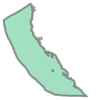

In [4]:
CalCS_shp = select_shape(shp, 'LME_NAME', 'California Current')
CalCS_shp

In [5]:
def lat_lon_formatter(ax):
    """
    Creates nice latitude/longitude labels
    for maps
    """
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(labelsize=16)
    

def set_up_map(ax, x0, x1, y0, y1):
    """
    Adds coastline, etc.
    
    x0, x1: longitude bounds to zoom into
    y0, y1: latitude bounds to zoom into
    """
    # set up land overlay
    ax.add_feature(cfeature.LAND, facecolor='k')
    
    # zoom in on region of interest
    ax.set_extent([x0, x1, y0, y1])
    
    # set nicer looking ticks
    ax.set_xticks(np.arange(x0, x1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(y0, y1, 10), crs=ccrs.PlateCarree())
    lat_lon_formatter(ax)

## California Current Demo

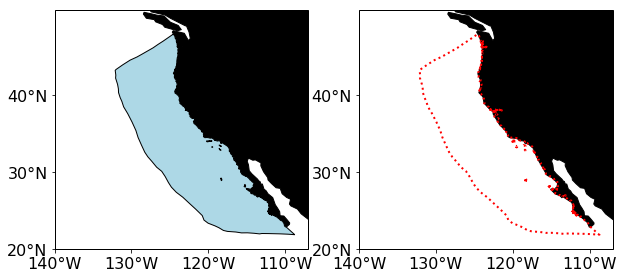

In [6]:
f, ax = plt.subplots(ncols=2, figsize=(10,5),
                     subplot_kw=dict(projection=ccrs.PlateCarree()))
set_up_map(ax[0], -140, -107, 20, 50)
set_up_map(ax[1], -140, -107, 20, 50)



# add shapefile to map
ax[0].add_patch(PolygonPatch(CalCS_shp, fc='#add8e6', zorder=4))
# some other attributes to play around with
ax[1].add_patch(PolygonPatch(CalCS_shp, fc='None', ec='r', linewidth=2,
                             linestyle=':'))

## Color Masks by Some Data

---

Can we color our shape files based on some quantitative data? Similar to a choropleth in GIS.

In [7]:
import matplotlib
import cartopy.crs as ccrs
import geoplot.crs as gcrs

In [8]:
shp = load_shape_file('LMEs/LMEs66.shp')
shp.head()

,OBJECTID,LME_NUMBER,LME_NAME,GROUPING,ARCTIC,USLMES,Shape_Leng,Shape_Area,SUM_GIS_KM,geometry
0,1,23.0,Baltic Sea,None,None,None,219.326402,61.950021,3.951472e+05,"POLYGON ((10.97943973554271 54.38055038418429,..."
1,2,52.0,Sea of Okhotsk,None,None,None,145.932989,213.796584,1.561297e+06,"POLYGON ((156.7070450503869 51.18857905056069,..."
2,3,22.0,North Sea,None,None,None,209.486403,103.965247,6.938472e+05,"POLYGON ((5.278888225314518 61.98027038609212,..."
3,4,2.0,Gulf of Alaska,None,None,Yes,495.473780,211.045622,1.530668e+06,POLYGON ((-149.4114074707736 61.49637985210421...
4,5,9.0,Labrador - Newfoundland,Arctic,Arctic,None,270.847479,114.597691,9.077923e+05,(POLYGON ((-64.56793350674803 60.4550934642860...


### Solution 1: Just use GeoPandas native plot ability.

---

Easiest way but doesn't let you tweak your map as much. There's a lot in the below reference that could be used much better than I used it.

Reference: http://geopandas.org/gallery/plotting_with_geoplot.html

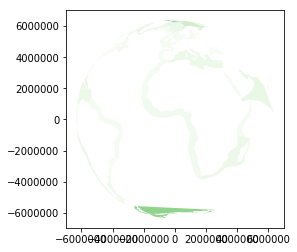

In [9]:
# Define the CartoPy CRS object.
crs = ccrs.Orthographic()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df = shp.to_crs(crs_proj4)

# Here's what the plot looks like in GeoPandas
ax = df.plot(column='Shape_Area', cmap='Greens')

### Solution 2: Manually create colormap

---

This seems preferred since we can leverage all of cartopy's features and our method of adding shapefiles.


Reference: https://gis.stackexchange.com/questions/199288/python-color-canadian-provinces-in-a-shapefile-based-on-given-values

In [13]:
# The data of interest should map to the same indices as your shape files,
# such as LMEs.
total_area = shp['Shape_Area'].values
total_area

array([  61.95002083,  213.79658433,  103.9652466 ,  211.04562178,
        114.59769105,   98.76234894,  106.4723238 ,   61.2565279 ,
         32.82897845,  215.80474439,   51.53428045,   34.46993029,
        256.74516848,   32.64916394,  125.30692921,   44.31324943,
        100.88447633,   72.65292052,   28.3566505 ,   20.08767998,
        137.23483119,  333.7834462 ,   40.03099102,   87.00886967,
        276.60375166,  264.39735731,  304.14862517,  165.39739227,
         82.97198949,   31.86466527,   86.10546653,  156.53424018,
         68.5710742 ,  184.89796521,   89.28660914,  253.06909724,
        128.34895907,   64.92069895,  109.05087309,  232.56965593,
         77.34806371,   60.6370155 ,   51.87599868,  103.1440359 ,
        137.36485309,  127.89582666, 1341.22332028,  100.61149023,
         53.20192097,   17.61440056,   97.1401216 ,  347.56076119,
        232.30978104,  678.86112464,  353.2011834 ,  303.97769292,
        187.92018455,  111.53247693,   32.31120891,  190.73872

In [11]:
def make_colormap(data, cmap_name, norm='linear'):
    """
    Make colormap for mapping shapefiles to.
    
    data: an array of data that the colormap will map to.
    cmap_name: string of a matplotlib colormap.
    norm: defaults to 'linear'. Pass 'log' for logarithmic colorbar.
    """
    cmap = matplotlib.cm.get_cmap(cmap_name)
    if norm == 'linear':
        norm = matplotlib.colors.Normalize(min(data), max(data))
    elif norm == 'log':
        norm = matplotlib.colors.LogNorm(min(total_area), max(total_area))
    else:
        raise ValueError("Supply 'linear' or 'log' for norm.")
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm._A = [] # some weird bug to make sure we can plot our colorbar later.
    return sm

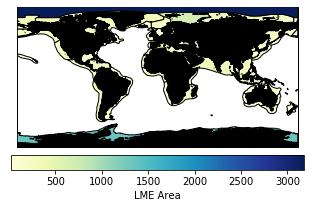

In [12]:
f, axes = plt.subplots(figsize=(8,3),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))

# Learning how to iterate cleanly is a good skill in python.
# Here, enumerate returns a tuple of values. First a counter
# (just like if you did i += 1 at the end of every loop) and second,
# the value fhmom the list you're iterating through.
#
# Here, I am just iterating through the LME names to plot them
# one by one. The i will be used to reference our total_area array
# and color it.
sm = make_colormap(total_area, 'YlGnBu')
for i, LME in enumerate(shp['LME_NAME'].values):
    poly = select_shape(shp, 'LME_NAME', LME)
    color = sm.to_rgba(total_area[i])
    test = axes.add_patch(PolygonPatch(poly, fc=color, zorder=4))
axes.axis('scaled')
axes.add_feature(cfeature.LAND, color='k')

# add colorbar.
# reference: https://stackoverflow.com/questions/35873209/matplotlib-add-colorbar-to-cartopy-image
cb = plt.colorbar(sm, orientation='horizontal', pad=0.05, fraction=0.09)
cb.set_label('LME Area')